In [1]:
# import utilities
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import string
import time
import math
import re

# import visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as f

import os
print(os.listdir("../input"))

['Organizations.csv', 'Forums.csv', 'Datasources.csv', 'KernelVotes.csv', 'DatasetTags.csv', 'KernelTags.csv', 'KernelVersionOutputFiles.csv', 'CompetitionTags.csv', 'DatasourceObjects.csv', 'UserOrganizations.csv', 'KernelVersionCompetitionSources.csv', 'Tags.csv', 'UserAchievements.csv', 'ForumTopics.csv', 'KernelVersionKernelSources.csv', 'DatasetVersions.csv', 'KernelVersions.csv', 'TeamMemberships.csv', 'ForumMessageVotes.csv', 'Datasets.csv', 'Kernels.csv', 'Competitions.csv', 'Submissions.csv', 'Teams.csv', 'DatasetVotes.csv', 'KernelLanguages.csv', 'DatasourceVersionObjectTables.csv', 'KernelVersionDatasetSources.csv', 'ForumMessages.csv', 'Users.csv', 'UserFollowers.csv']


![image](https://github.com/Lexie88rus/sequence-models/raw/master/assets/antique-book-book-bindings-2355408.jpg)

# Kaggle Titles Generation with PyTorch LSTM

## Introduction

When I first found out about [sequence models](https://medium.com/machine-learning-bites/deeplearning-series-sequence-models-7855babeb586), I was amazed with how easily they can be applied to a wide range of problems: text classification, text generation, music generation, machine translation and others. I shared some great resources on sequence models and LSTM in `"References and Further Reading"` section below. You might want to explore them before going through the rest of this kernel, because in this kernel I would like to focus on step-by-step process of creation a model and not on sequence models theory.

I got an idea to use [Meta Kaggle](https://www.kaggle.com/kaggle/meta-kaggle) dataset to train a model for generation of new kernel titles. This could help to capture some trends for Kaggle kernels and give an inspiration. In this kernel:
* I loaded and preprocessed Kaggle data on kernels.
* Implemented and trained a sequence model for generation of new Kaggle titles.

## Load Data

At first I need to load the data. I will load `Kernels` and `KernelVersions` tables, which contain information on all kernels, total number of votes per kernel (later I will explain why we need this) and kernel titles.

In [2]:
# Load data
# Load kernel versions
kernel_versions = pd.read_csv('../input/KernelVersions.csv')
# Load kernels (to retreive TotalVotes)
kernels = pd.read_csv('../input/Kernels.csv')

## Make a List of Popular Kernel Titles

Next step is to make a list of most popular kernel titles, which will be then converted into word sequences and passed to the model. It comes out that kernel titles are __extremely untidy__: misspelled words, foreign words, special symbols or just have poor names like 'kernel678hggy'.

That is why:
* __I will drop kernels without votes from the analysis__. I will assume that kernels, which have votes are of better quality and have more meaningful titles.
* I will sort kernels by the total number of votes and __take only the most voted ones__.

In [3]:
# Merge kernels and versions to retreive kernel title and total votes for kernel
kernels_trc = kernels[['CurrentKernelVersionId', 'TotalVotes']].rename(columns={'CurrentKernelVersionId' : 'Id'})
kernel_version_trc = kernel_versions[['Id', 'Title']]
kernels_titles_votes = kernels_trc.merge(kernel_version_trc)

# Sort titles by the number of votes
kernels_titles_votes = kernels_titles_votes.sort_values(by=['TotalVotes'])

# Retreive the list of popular kernel titles (at leat 1 vote)
popular_kernel_titles = kernels_titles_votes[kernels_titles_votes['TotalVotes'] > 0]['Title'].unique().tolist()

# Print out some examples
popular_kernel_titles[:10]

['Exploring the Dataset',
 'Logistic regression analysis',
 'Dogs vs. Cats Classification (VGG16 Fine Tuning)',
 'Testing',
 'Polynomial Regression',
 'Cosine Distance',
 'reddit play',
 'XGBoost on Credit Card Fraud Detection',
 'An Interactive Data Science Tutorial e67527',
 'PCA_BC']

Print out some statistics:

In [4]:
print('Total number of kernels is {}.'.format(len(kernels)))
print('Total number of kernels with at leat 1 upvote is {}.'.format(len(popular_kernel_titles)))

Total number of kernels is 252866.
Total number of kernels with at leat 1 upvote is 50335.


## Preprocess Kernel Titles and Create Vocabulary

I decided to try a __word based model__. That's why in the next step I will need to __create a vocabulary__, which then should be used to encode word sequences. 

To create the vocabulary we have to do the following steps:
* Clean each title to remove punctuation and lowercase all the words.
* Split each title to words and add each word to the vocabulary.
* Introduce a symbol, which denotes the end of the title (I chose `.`, but you can change it) and add it to the vocabulary.

Introduce a function to clean kernel titles:

In [5]:
# Lowercase, remove punctuation and numbers from kernel titles
def clean_title(title):
    '''
    Function to lowercase, remove punctuation and numbers from kernel titles
    '''
    # lowercase
    title = str(title).lower()
    # replace punctuation into spaces
    title = re.sub(r"[,.;@#?!&$%<>-_*/\()~='+:`]+\ *", " ", title)
    title = re.sub('-', ' ', title)
    title = re.sub("''", ' ', title)
    # replace numbers into spaces
    title = re.sub(r"[0123456789]+\ *", " ", title)
    #remove duplicated spaces
    title = re.sub(' +', ' ', title)
    
    return title.strip()

Introduce a symbol for the end of title and a word extraction function:

In [6]:
# Extract words from kernel titles
end_of_sentence = '.' # symbol to denote the end of the sentence
def extract_words(title):
    '''
    Function which transforms kernel title into a list of words ending with 'end_of_sentence' word.
    '''
    title = clean_title(title)
    words = title.split(' ')

    return words

Function to create a vocabulary out of a list of titles:

In [7]:
def create_vocabulary(titles):
    '''
    Function to create a vocabulary out of a list of titles
    '''
    vocab = set()
    
    for title in titles:
        if (clean_title(title) != ''):
            words = extract_words(title)
            vocab.update(words)
        
    word_list = list(vocab)
    word_list.append(end_of_sentence)
    vocabulary = {word_list[n]:n for n in range(0,len(word_list))}
    
    return vocabulary

Create the vocabulary out of kernel titles:

In [8]:
# create vocabulary out of pipular kernel titles
vocab = create_vocabulary(popular_kernel_titles)
vocab_size = len(vocab)

Print out some statistics:

In [9]:
print('There are {} words in vocabulary.'.format(vocab_size))

There are 17711 words in vocabulary.


## Create the Training Set

In this section we will create a training set for our future model:
* __Introduce functions which encode each word into tensor__ using the vocabulary created above. I will use one-hot encoding of words: each word will be represented as a tensor with zeros and ones with all zeros and one in the position which respects to the index of the word in the vocabulary.
* __Generate sequences out of kernel titles.__ The length of the sequence is a hyperparameter. I chose sequence length equal to 3. So we will give the model a tensor containing encoding for 3 words and a prediction target, which contains the index of the 4th consequent word.

In [10]:
# Translate word to an index from vocabulary
def wordToIndex(word):
    if (word != end_of_sentence):
        word = clean_title(word)
    return vocab[word]

# Translate word to 1-hot tensor
def wordToTensor(word):
    tensor = torch.zeros(1, 1, vocab_size)
    tensor[0][0][wordToIndex(word)] = 1
    return tensor

# Turn a title into a <title_length x 1 x vocab_size>,
# or an array of one-hot vectors
def titleToTensor(title):
    words = extract_words(title)
    tensor = torch.zeros(len(words) + 1, 1, vocab_size)
    for index in range(len(words)):
        tensor[index][0][wordToIndex(words[index])] = 1
    
    tensor[len(words)][0][vocab[end_of_sentence]] = 1
    return tensor

# Turn a sequence of words from title into tensor <sequence_length x 1 x vocab_size>
def sequenceToTensor(sequence):
    tensor = torch.zeros(len(sequence), 1, vocab_size)
    for index in range(len(sequence)):
        tensor[index][0][wordToIndex(sequence[index])] = 1
    return tensor

Demonstrate the utility functions:

In [11]:
# Demonstrate functions above
print('Index of "love" in vocabulary is {}'.format(wordToIndex('love')))
print('Index of "LoVE" in vocabulary is {}'.format(wordToIndex('LoVE')))

print('Tensor representation of "Fiddling With Python" is:')
title_tensor = titleToTensor('Fiddling With Python')
print(title_tensor)

print('Dimensions of title tensor: {}'.format(title_tensor.size()))

Index of "love" in vocabulary is 15422
Index of "LoVE" in vocabulary is 15422
Tensor representation of "Fiddling With Python" is:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 1.]]])
Dimensions of title tensor: torch.Size([4, 1, 17711])


Generate word sequences:

In [12]:
# Generate sequences out of titles:

# Define sequence length
sequence_length = 3

# Generate sequences
def generate_sequences(titles):
    sequences = []
    targets = []
    # Loop for all selected titles
    for title in titles:
        # Run through each title
        if clean_title(title) != '' and clean_title(title) != ' ':
            words = extract_words(title)
            words.append(end_of_sentence)

            for i in range(0, len(words) - sequence_length):
                sequence = words[i:i + sequence_length]
                target = words[i + sequence_length:i + sequence_length + 1]

                sequence_tensor = sequenceToTensor(sequence)
                target_tensor = sequenceToTensor(target)

                sequences.append(sequence_tensor)
                targets.append( target_tensor)
            
    return sequences, targets

In [13]:
sequences, targets = generate_sequences(popular_kernel_titles[:5000])

## Build the Model

The next step is building a simple __LSTM model__ with:
* __Input and output sizes__ of the model should be equal to the size of the vocabulary, because we are trying to predict the next word for a sequence;
* __LSTM block__ with 128 hidden units;
* One __linear layer__ to translate from hidden size into the output size;
* __Softmax activation__.

In [14]:
# Create LSTM
class SimpleLSTM(nn.Module):
    '''
    Simple LSTM model to generate kernel titles.
    Arguments:
        - input_size - should be equal to the vocabulary size
        - output_size - should be equal to the vocabulary size
        - hidden_size - hyperparameter, size of the hidden state of LSTM.
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        
        output = self.linear(output[-1].view(1, -1))
        
        output = self.softmax(output)
        return output, hidden

    # the initialization of the hidden state
    # device is cpu or cuda
    # I suggest using cude to speedup the computation
    def initHidden(self, device):
        return (torch.zeros(1, 1, n_hidden).to(device), torch.zeros(1, 1, n_hidden).to(device))

# Initialize LSTM
n_hidden = 128
rnn = SimpleLSTM(vocab_size, n_hidden, vocab_size) # inputs and outputs of RNN are tensors representing words from the vocabulary

In [15]:
# Define a function which converts output into word
def wordFromOutput(output):
    '''
    Functions returns an index from the vocabulary and the corresponding word
    '''
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return [k for (k, v) in vocab.items() if v == category_i], category_i

Try the model with a sigle forward pass:

In [16]:
# test forward pass of the model
input = titleToTensor('Fiddling with')
hidden = (torch.zeros(1, 1, n_hidden), torch.zeros(1, 1, n_hidden))

output, next_hidden = rnn(input[0], hidden)

print(output)
wordFromOutput(output)

tensor([[-9.7171, -9.7455, -9.8290,  ..., -9.7909, -9.7488, -9.7084]],
       grad_fn=<LogSoftmaxBackward>)


(['occupation'], 13135)

## Train the Model

Now the dataset and the model are ready and we can start training:

Introduce a function, which converts a tensor representing a word into an index from the vocabulary:

In [17]:
# Define a function to convert tensor into index in vocabulary
def indexFromTensor(target):
    '''
    Function returns tensor containing target index given tensor representing target word
    '''
    top_n, top_i = target.topk(1)
    target_index = top_i[0].item()
    
    target_index_tensor = torch.zeros((1), dtype = torch.long)
    target_index_tensor[0] = target_index
    return target_index_tensor

Set up learning rate and loss function:

In [18]:
learning_rate = 0.005 
criterion = nn.NLLLoss()

Set up the device for training:

_Don't forget to enable GPU in the kernel settings!_

In [19]:
# device to use
# don't forget to turn on GPU on kernel's settings
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Define training procedure:

In [20]:
# Define training procedure
def train(sequence, target, device):
    # Move tensors to device
    hidden = rnn.initHidden(device)
    sequence = sequence.to(device)
    target = target.to(device)

    rnn.zero_grad()

    # Forward step
    for i in range(sequence.size()[0]):
        output, hidden = rnn(sequence[i], hidden)
        
    output, hidden = rnn(sequence[i], hidden)
    
    loss = criterion(output, indexFromTensor(target).to(device))
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Train the model:

In [21]:
# Set up the number of iterations, printing and plotting options
n_iters = 1100000
print_every = 1000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

rnn = rnn.to(device)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# shuffle indices
indices = np.random.permutation(len(sequences))

start = time.time()

# run training procedure
for iter in range(1, n_iters + 1):
    
    # Pick index
    index = indices[iter % len(sequences)]
    
    # Run one training step
    output, loss = train(sequences[index], targets[index][0].long(), device)
    current_loss += loss

    # Print iter number and loss
    if iter % print_every == 0:
        guess, guess_i = wordFromOutput(output)
        print('%d %d%% (%s) Loss: %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 0% (0m 6s) Loss: 9.8408
2000 0% (0m 12s) Loss: 0.8920
3000 0% (0m 19s) Loss: 0.8882
4000 0% (0m 25s) Loss: 8.8508
5000 0% (0m 31s) Loss: 10.4614
6000 0% (0m 37s) Loss: 10.1815
7000 0% (0m 44s) Loss: 10.3908
8000 0% (0m 50s) Loss: 4.4504
9000 0% (0m 56s) Loss: 10.6149
10000 0% (1m 3s) Loss: 5.5505
11000 1% (1m 9s) Loss: 9.0928
12000 1% (1m 15s) Loss: 10.2472
13000 1% (1m 22s) Loss: 7.7047
14000 1% (1m 28s) Loss: 9.8725
15000 1% (1m 34s) Loss: 0.8282
16000 1% (1m 41s) Loss: 4.8312
17000 1% (1m 47s) Loss: 0.6791
18000 1% (1m 53s) Loss: 4.2040
19000 1% (2m 0s) Loss: 10.7534
20000 1% (2m 6s) Loss: 9.1553
21000 1% (2m 12s) Loss: 1.1733
22000 2% (2m 19s) Loss: 1.0591
23000 2% (2m 25s) Loss: 9.8517
24000 2% (2m 31s) Loss: 1.3558
25000 2% (2m 38s) Loss: 10.2830
26000 2% (2m 44s) Loss: 9.7673
27000 2% (2m 50s) Loss: 5.4188
28000 2% (2m 56s) Loss: 5.5243
29000 2% (3m 3s) Loss: 5.1331
30000 2% (3m 9s) Loss: 0.8617
31000 2% (3m 15s) Loss: 10.3859
32000 2% (3m 22s) Loss: 11.2339
33000 3% (3m 28

Plot training statistics:

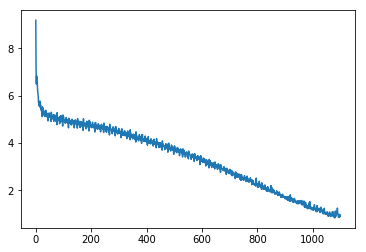

In [22]:
# plot training loss
plt.figure()
plt.plot(all_losses)

We should see that __training loss is decreasing__ over the number of epochs.

## Sample Kernel Titles from the Model

Now we can use our trained model to generate new kernel titles! All we need to do is to write a simple sampling procedure:
* Introduce the maximum number of words in the title (10 for example);
* Pass zero tensors to the model as the initial word and hidden state;
* Repeat following steps until the end of the title symbol is sampled or the number of maximum words in title exceeded:

    * Use the probabilities from the output of the model to get the next word for a sequence;
    * Pass sampled word as a next input for the model.

In [23]:
# Sample title from the trained model
def sample():   
    num_words = 10
    
    # Initialize input step and hidden state
    input = torch.zeros(1, 1, vocab_size)
    hidden = (torch.zeros(1, 1, n_hidden).to(device), torch.zeros(1, 1, n_hidden).to(device))
    
    i = 0
    output_word = None
    sentence = []
    # Sample words from the model
    while output_word != '.' and i < num_words:
          
        input = input.to(device)
        output, next_hidden = rnn(input[0], hidden)
        
        y = output.clone()
        y = y.to(device)
        # use probabilities from the output to choose the next word
        idx = np.random.choice(range(vocab_size), p = f.softmax(y, dim=1).detach().cpu().numpy().ravel())
        
        output_word = [k for (k, v) in vocab.items() if v == idx][0]
        sentence.append(output_word)
         
        hidden = next_hidden
        input = wordToTensor(output_word)
        i = i+1
        
    return sentence

Sample 15 titles from the model:

In [24]:
# sample 15 titles and print
for i in range(15):
    sampled_title = sample()
    title = ' '.join(sampled_title)
    print(title)
    print("\n")

simply entity graph ezgi .


missingno step only using .


onlylogisticregression digitrecog d r .


悟空 porcupine .


dinner lesson web screening .


south uniq .


tyler pokemongo on r am data data lb .


caretrun crew notebo only .


pics clearer | colorado using only .


elasticnet playground .


gtlv excavating fine blackjack using .


ortools estonia d analyzer .


combos maritime .


lifespan quit d using .


hoxosh aufgabe unfinished behaviour .




Save the model weights for later:

In [25]:
# save the model for later
checkpoint = {'input_size': vocab_size,
          'output_size': vocab_size,
          'hidden_size': n_hidden,
          'state_dict': rnn.state_dict()}

torch.save(checkpoint, 'rnn.pth')

## Conclusion


In this kernel:
* I loaded and did a simple preprocessing of real text data.
* I created a sequence word based model, which can be used to generate new kernel titles.

You can see that the model doesn't generate something that makes sence, but there are still some funny results like these:
* "wealth bowl datamining"
* "supplement approved databases"
* "plane ignore population competition"
* "projecting superfood prescribing survey"
* "mediation cta aluminum kernals reviews"

This happens when models crush into a __real life data__. They contain abbreviations, nicknames, words in different languages, misspelled words and a lot more. Of course, these results can be improved by __better data preprocessing__. I decsribed actions to improve the results in `"Further Improvement"` section below.

## Further Improvement
Though I managed to get some interesting results, there is a lot what should be done here:
* __Better data cleaning__: a lot of titles should be removed from the analysis as they are not in English or they're just can't be used (for example 'kernel123').
* __Auto-correction of misspelled words__: titles can be preprocessed with automatic correction of misspelled words (for example, consider [PySpell package](https://facelessuser.github.io/pyspelling/)). I could add this to this kernel, but this would run too long for Kaggle. But this is still an option since data preprocessing happens just one time before training and preprocessed data could be saved for later.
* __Hyperparameter tuning__: I suppose that learning rate and sequence length can be tuned to achieve even better results.
* __Use [word embeddings](https://hackernoon.com/word-embeddings-in-nlp-and-its-applications-fab15eaf7430) instead of one-hot encoding__ for words.

## References and Further Reading
I also want to share some great resources on RNNs and LSTM:
1. [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/): Article about RNNs and their use cases.
2. [Long Short-Term Memory: From Zero to Hero with PyTorch](https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/): PyTorch implementation of LSTMs.
3. [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/): another LSTM implementation.
4. [Exercise: Sampling from an RNN](https://pytorch-nlp-tutorial-ny2018.readthedocs.io/en/latest/day2/sampling.html): examples of sampling from RNN.